### Imports

In [1]:
# 00. Imports
from __future__ import annotations

import json
from pathlib import Path

import numpy as np                  # type: ignore
import pandas as pd                 # type: ignore
import matplotlib.pyplot as plt     # type: ignore

from notebooks.shared.n02_explore_dataset.eda_core import (
    DescriptiveAnalyzer, OutlierDetector, TemporalAnalyzer,
    StatisticalTester, FeatureImportanceAnalyzer, ensure_temporal_columns,
    plot_correlation_heatmap,
)
from notebooks.shared.common.utils import canonical_json_dumps
from notebooks.shared.n02_explore_dataset.eda_reports import InsightsAnalyzer, EDAReportRunner
from notebooks.shared.common.utils import NumpyJSONEncoder, log_basic_diagnostics
from notebooks.shared.common.constants import (
    VALUATION_K, ENERGY_CLASS, CONDITION_SCORE, RISK_SCORE,
    LUXURY_SCORE, ENV_SCORE, SIZE_M2, LAG_HOURS, LOCATION
)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["figure.dpi"] = 110

### Setup

In [2]:
# 01: Setup
ANALYSIS_DIR = Path("outputs/analysis"); ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = ANALYSIS_DIR / "figures"; FIG_DIR.mkdir(parents=True, exist_ok=True)

# helper salvataggio figure
def _savefig(name, dpi=120, bbox_inches="tight"):
    # FIG_DIR deve essere un Path valido, es. FIG_DIR = ANALYSIS_DIR / "figures"
    name = Path(name)
    path = (FIG_DIR / name) if not name.is_absolute() else name
    path = path.with_suffix(".png") if path.suffix == "" else path
    path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(path, dpi=dpi, bbox_inches=bbox_inches)
    print(f"📈 Figure saved: {path}")

# carica ultimo manifest di nb01
snapshots_dir = Path("outputs/snapshots")
manifests = sorted(snapshots_dir.glob("manifest_*.json"))
assert manifests, "Nessun manifest trovato in outputs/snapshots. Esegui nb01 export prima."
manifest01_path = manifests[-1]
with open(manifest01_path, "r", encoding="utf-8") as f:
    manifest01 = json.load(f)

dataset_path = Path(manifest01["paths"]["dataset"])
assert dataset_path.exists(), f"Dataset non trovato: {dataset_path}"

# leggi dataset (csv/parquet)
df = pd.read_parquet(dataset_path) if dataset_path.suffix.lower()==".parquet" else pd.read_csv(dataset_path)

# colonne temporali coerenti (best-effort) + diagnostica
df = ensure_temporal_columns(df)
log_basic_diagnostics(df)

print(f"Loaded dataset: {dataset_path}  → rows={len(df):,}, cols={df.shape[1]}")

Loaded dataset: outputs\dataset_generated.csv  → rows=15,000, cols=47


### Report Loading & Distribution Analysis — 2.1 Upload nb01 report

In [3]:
# 02.1: Carica report di nb01 (robusto, cross-OS, con fallback)
from pathlib import Path
from typing import Optional, Dict, Any
import json

paths = manifest01.get("paths", {}) if isinstance(manifest01, dict) else {}

quality_path = Path(paths.get("quality_report_json", "outputs/quality_report.json"))
sanity_path  = Path("outputs/sanity_report.json")
drift_path = Path("outputs/analysis/location_drift_generation.json")
profiling_path = Path("outputs/analysis/profiling_report.json")

def _load_json(p: Optional[Path]) -> Dict[str, Any]:
    if not p or not p.exists():
        return {}
    try:
        with open(p, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception:
        return {}

reports01 = {
    "quality": _load_json(quality_path),
    "sanity": _load_json(sanity_path),
    "profiling": _load_json(profiling_path),
    "location_drift": _load_json(drift_path),
}

print("Artefatti caricati:", [k for k, v in reports01.items() if v])
print("CWD:", Path.cwd().resolve())
print("Profiling path:", profiling_path if profiling_path else "not found")

Artefatti caricati: ['quality']
CWD: C:\Users\Utente\Desktop\Projects\ai_oracle_rwa\notebooks
Profiling path: outputs\analysis\profiling_report.json


### Report Loading & Distribution Analysis — 2.2 Distribuzione per location

In [4]:
# 02.2: Distribuzione per location (API top-level) + export
from notebooks.shared.common.reports import DistributionAnalyzer

dist = DistributionAnalyzer(df)
loc_analysis = dist.analyze_location(
    target_weights=(reports01.get("sanity", {}).get("expected_profile", {}) or {}).get("location_weights"),
    tolerance=(reports01.get("sanity", {}).get("expected_profile", {}) or {}).get("location_distribution_tolerance", 0.05),
)

loc_counts = loc_analysis.get("counts", {}) or {}
loc_pcts   = loc_analysis.get("percentages", {}) or {}

loc_df = pd.DataFrame({
    "count": pd.Series(loc_counts, dtype="Int64"),
    "pct":   pd.Series(loc_pcts, dtype="float"),
}).fillna(0).sort_values("count", ascending=False)

display(loc_df.head(20))

loc_csv  = ANALYSIS_DIR / "location_distribution.csv"
loc_parq = ANALYSIS_DIR / "location_distribution.parquet"
loc_df.to_csv(loc_csv, encoding="utf-8")
loc_df.to_parquet(loc_parq)
print(f"Saved: {loc_csv}, {loc_parq}")

,count,pct
Milan,3017,20.1
Rome,2700,18.0
Turin,1214,8.1
Naples,1190,7.9
Bologna,886,5.9
Genoa,773,5.2
Florence,770,5.1
Palermo,767,5.1
Venice,596,4.0
Bari,593,4.0


Saved: outputs\analysis\location_distribution.csv, outputs\analysis\location_distribution.parquet


### Report Loading & Distribution Analysis — 2.3 Drift summary

In [5]:
# 02.3: Drift summary con fallback robusto
expected_profile = (reports01.get("sanity", {}).get("expected_profile", {}) or {})
expected = expected_profile.get("location_weights", {}) or {}
tolerance = expected_profile.get("location_distribution_tolerance", 0.05)

# Fallback A: prova a usare gli expected salvati nel drift di nb01 (se presente)
if not expected and reports01.get("location_drift"):
    diffs_nb01 = reports01["location_drift"].get("differences", {}) or {}
    expected = {k: float(v.get("expected", 0.0) or 0.0) for k, v in diffs_nb01.items()}

# Fallback B: se ancora vuoto, non facciamo drift check (baseline assente)
if not expected:
    print("ℹ️ Nessun expected_profile disponibile → salto il drift check (baseline mancante).")
    drift_report = {
        "tolerance": tolerance,
        "drifted_locations": [],
        "differences": {},
        "nb01_drift": reports01.get("location_drift", {}),
        "summary": loc_analysis.get("summary", {}),
        "note": "No baseline → drift check skipped",
    }
else:
    obs_pct = loc_analysis.get("percentages", {}) or {}
    all_locs = sorted(set(expected.keys()) | set(obs_pct.keys()))
    drifted, differences = [], {}
    for loc in all_locs:
        exp = float(expected.get(loc, 0.0) or 0.0)
        obs = float(obs_pct.get(loc, 0.0) or 0.0)
        diff = obs - exp
        differences[loc] = {"expected": exp, "observed": obs, "difference": diff}
        if abs(diff) > tolerance:
            drifted.append(loc)
    drift_report = {
        "tolerance": tolerance,
        "drifted_locations": drifted,
        "differences": differences,
        "nb01_drift": reports01.get("location_drift", {}),
        "summary": loc_analysis.get("summary", {}),
    }
    if drifted:
        print("⚠️ Drift oltre soglia per:", drifted)

drift_json = ANALYSIS_DIR / "location_drift_eda.json"
drift_json.write_text(canonical_json_dumps(drift_report), encoding="utf-8")
print(f"Saved: {drift_json}")

ℹ️ Nessun expected_profile disponibile → salto il drift check (baseline mancante).
Saved: outputs\analysis\location_drift_eda.json


### Report Loading & Distribution Analysis — 2.4 Barplot top locations

📈 Figure saved: outputs\analysis\figures\top_locations_count.png


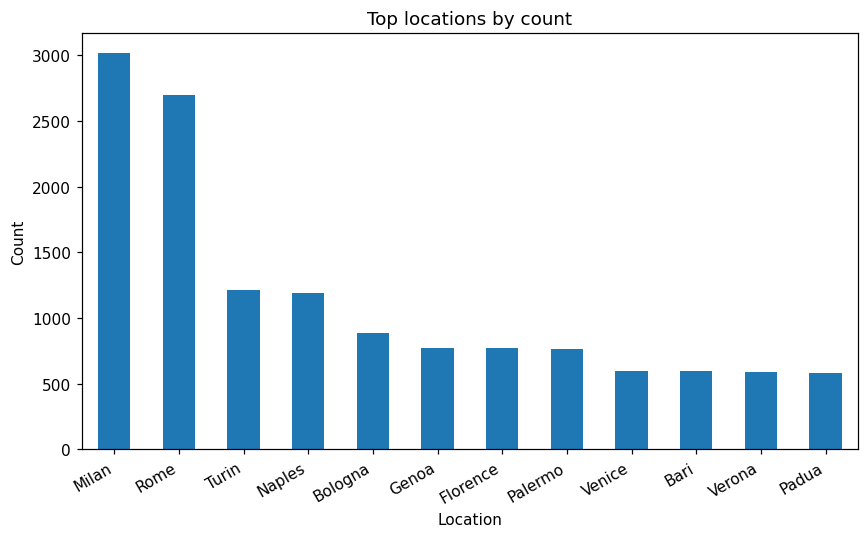

In [6]:
# 02.4: Barplot top locations (robusto, senza definire funzioni)
from pathlib import Path
fig_dir = Path("outputs/analysis/figures"); fig_dir.mkdir(parents=True, exist_ok=True)

if 'loc_df' in globals() and isinstance(loc_df, pd.DataFrame) and not loc_df.empty and "count" in loc_df:
    top = loc_df["count"].sort_values(ascending=False).head(12)
elif LOCATION in df.columns:
    top = df[LOCATION].value_counts(dropna=False).head(12)
else:
    top = pd.Series(dtype="int64")

if top.empty:
    print("⚠️ Nessuna location disponibile per il plot.")
else:
    ax = top.plot(kind="bar")
    ax.set_title("Top locations by count")
    ax.set_ylabel("Count")
    ax.set_xlabel("Location")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    _savefig("top_locations_count.png")
    plt.show()

### Report Loading & Distribution Analysis — 2.5 Salva anche hist prezzi

📈 Figure saved: outputs\analysis\figures\valuation_hist.png


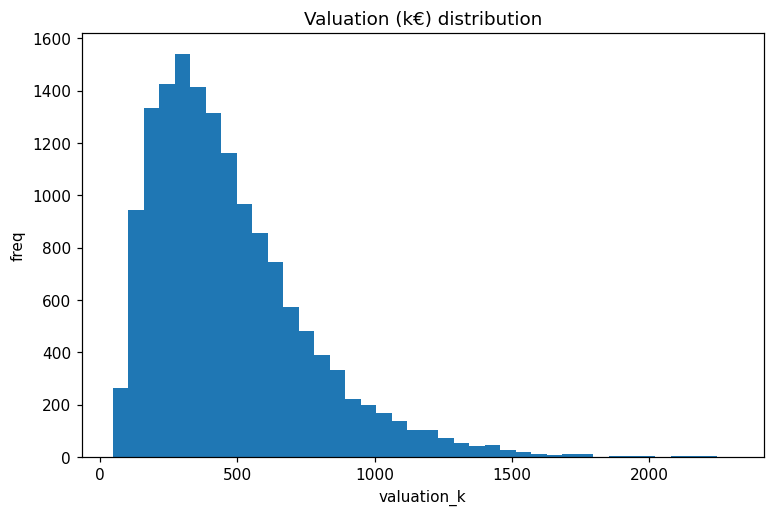

In [7]:
# 02.5: Istogramma valuation_k (extra rapido)
if VALUATION_K in df:
    df[VALUATION_K].plot(kind="hist", bins=40)
    plt.title("Valuation (k€) distribution"); plt.xlabel("valuation_k"); plt.ylabel("freq")
    _savefig("valuation_hist.png"); plt.show()

### Descriptive Statistics & Distributions — relationship plots

📈 Figure saved: outputs\analysis\figures\relationship_plots.png


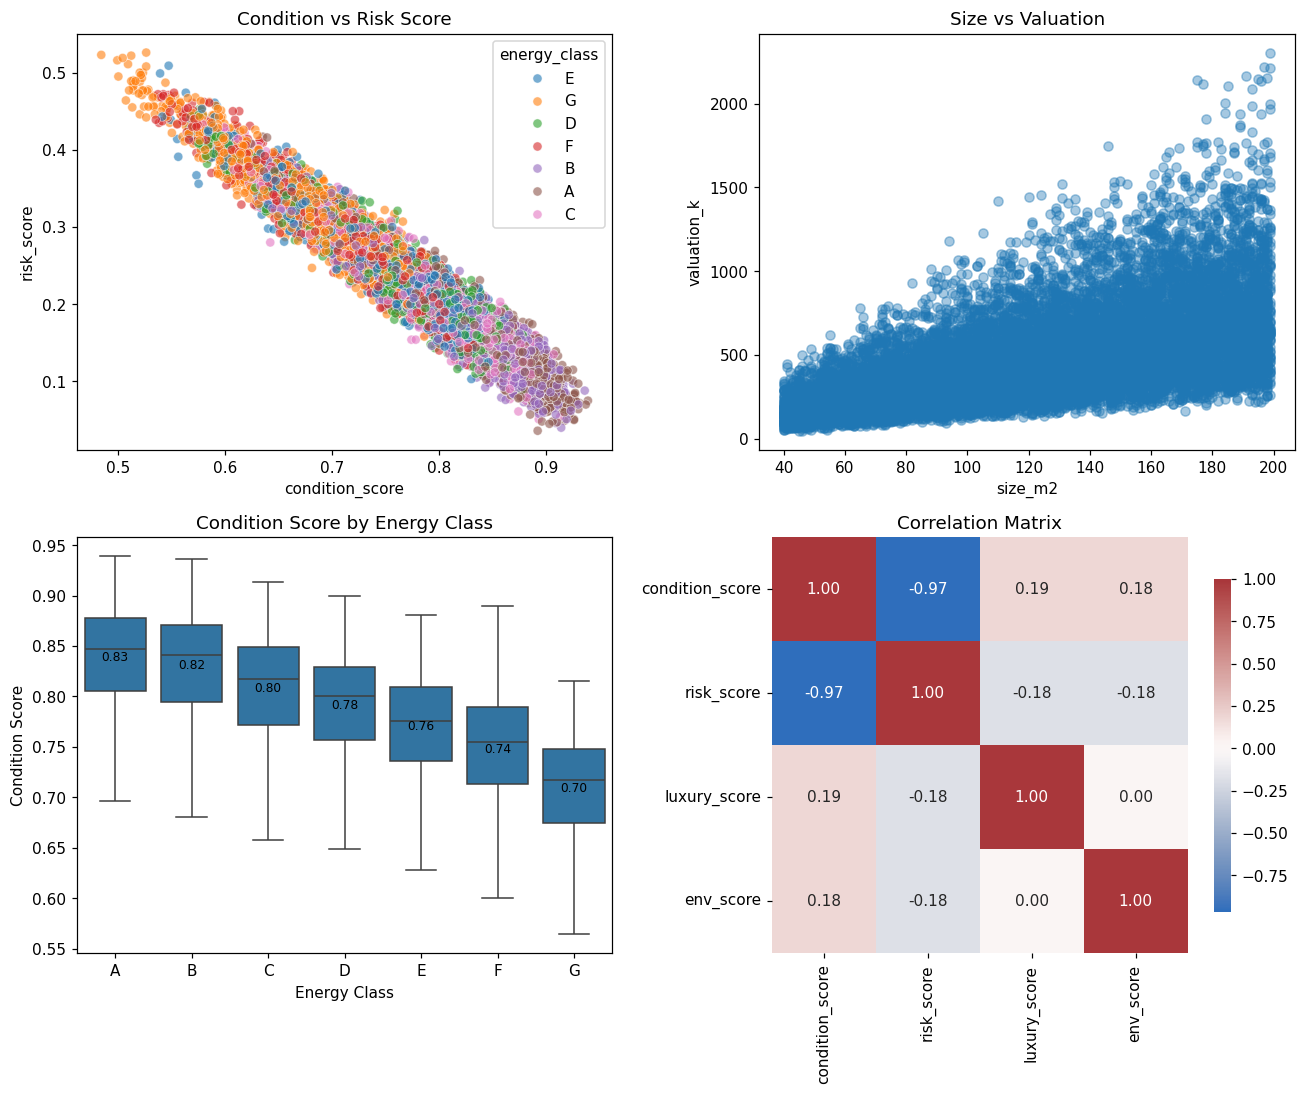

In [8]:
# 03.1: Relationship plots (scatter, regplot, boxplot, heatmap score)
desc = DescriptiveAnalyzer()
fig = desc.create_relationship_plots(df, figsize=(12,10))
_savefig("relationship_plots.png"); plt.show()

### Descriptive Statistics & Distributions — heatmap score


📈 Figure saved: outputs\analysis\figures\score_correlation_heatmap.png


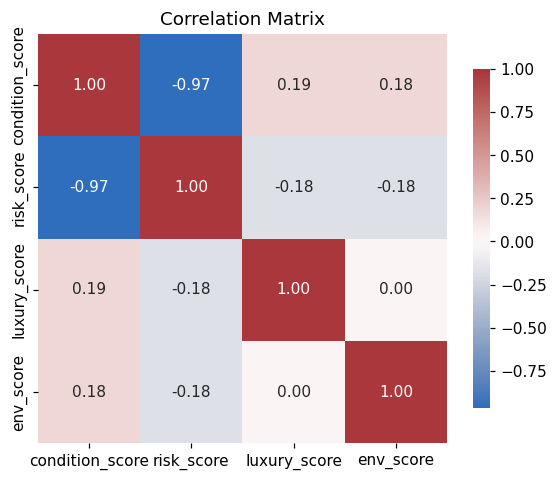

In [9]:
# 03.2: Heatmap correlazioni sugli score
score_cols = [c for c in [CONDITION_SCORE, RISK_SCORE, LUXURY_SCORE, ENV_SCORE] if c in df.columns]
if len(score_cols) >= 2:
    fig, ax = plt.subplots(1,1, figsize=(6,5))
    plot_correlation_heatmap(df, score_cols, ax=ax)
    _savefig("score_correlation_heatmap.png"); plt.show()

### Condition and Risk

📈 Figure saved: outputs\analysis\figures\condition_by_energy_boxplot.png


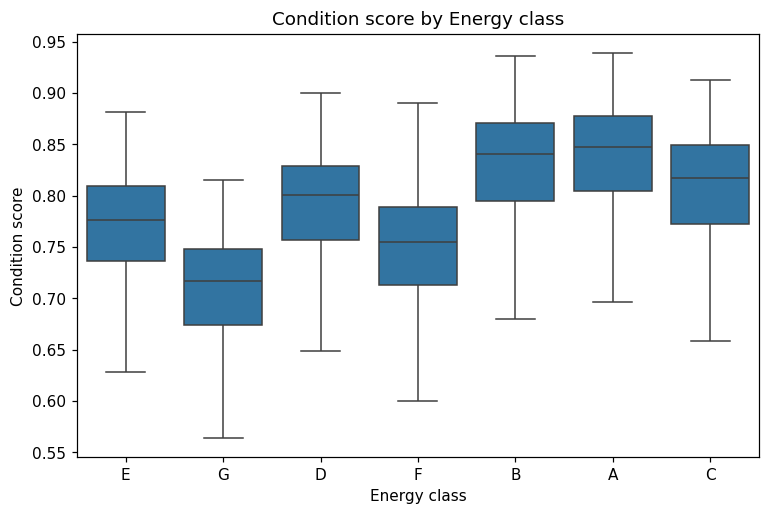

In [10]:
# 04: Condition vs Energy class – boxplot dedicato
if CONDITION_SCORE in df and ENERGY_CLASS in df:
    try:
        import seaborn as sns  # opzionale
        plt.figure(figsize=(8,5))
        sns.boxplot(data=df, x=ENERGY_CLASS, y=CONDITION_SCORE, showfliers=False)
        plt.title("Condition score by Energy class"); plt.xlabel("Energy class"); plt.ylabel("Condition score")
        _savefig("condition_by_energy_boxplot.png"); plt.show()
    except Exception as e:
        print(f"ℹ️ seaborn non disponibile: salto boxplot ({e})")

### Relations

In [11]:
# 05.1: Pearson corr con target
num_df = df.select_dtypes(include=[np.number])
if VALUATION_K in num_df:
    corr = num_df.corr(numeric_only=True)[VALUATION_K].drop(labels=[VALUATION_K], errors="ignore")
    top_pos = corr.sort_values(ascending=False).head(8)
    top_neg = corr.sort_values(ascending=True).head(8)
    top_abs = corr.abs().sort_values(ascending=False).head(12)
    corr_df = pd.DataFrame({"corr": corr})
    display(corr_df.loc[top_abs.index])
    corr_csv = ANALYSIS_DIR / "target_correlations.csv"
    corr_parq = ANALYSIS_DIR / "target_correlations.parquet"
    corr_df.to_csv(corr_csv, encoding="utf-8"); corr_df.to_parquet(corr_parq)
    print(f"Saved: {corr_csv}, {corr_parq}")

,corr
price_per_sqm,0.724941
size_m2,0.630403
luxury_score,0.379311
distance_to_center_km,-0.354913
confidence_score,0.280364
concierge,0.195561
year_built,0.178468
age_years,-0.178468
condition_score,0.110013
risk_score,-0.106360


Saved: outputs\analysis\target_correlations.csv, outputs\analysis\target_correlations.parquet


### Analisi statistica avanzata

In [12]:
# 06.1: Test statistici (normalità, χ², distribution stats) + summary
tester = StatisticalTester()
stats_results = tester.run_comprehensive_tests(df)
summary_df = pd.DataFrame([stats_results["summary"]])
display(summary_df)

stats_json = ANALYSIS_DIR / "stat_tests_results.json"
stats_json.write_text(canonical_json_dumps(drift_report), encoding="utf-8")
print(f"Saved: {stats_json}")

,normality,dependencies
0,"{'n_tested': 3, 'n_normal': 0, 'pct_normal': 0...","{'n_tested': 1, 'n_dependent': 1, 'dependent_p..."


Saved: outputs\analysis\stat_tests_results.json


### Temporal analysis

{'status': 'completed', 'temporal_stats': {'count': 15000, 'mean': 0.0, 'median': 0.0, 'pct_over_thresholds': {'30': 0.0, '60': 0.0, '90': 0.0}}, 'correlation': {'pearson': nan, 'spearman': nan}, 'regression': {'coef': 0.0, 'p_value': nan, 'r2': 0.0}}
📈 Figure saved: outputs\analysis\figures\temporal_analysis.png


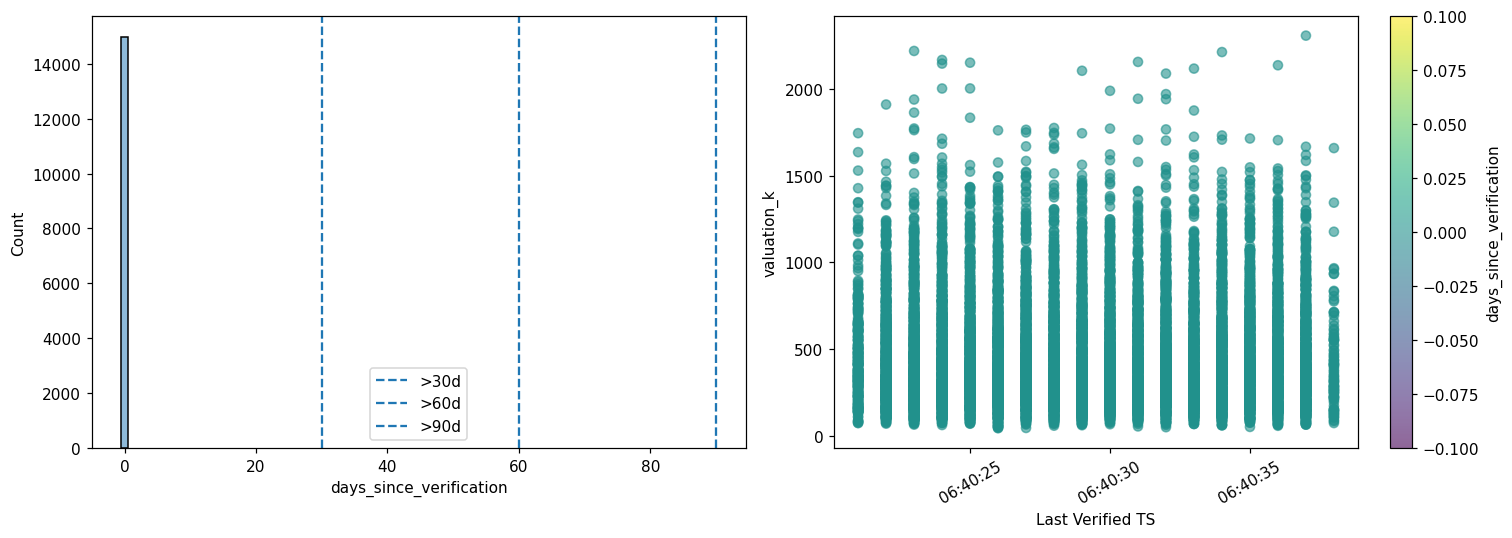

📈 Figure saved: outputs\analysis\figures\temporal_analysis.png
Saved: outputs\analysis\temporal_report.json
💾 Saved: outputs\analysis\freshness_by_location.csv, outputs\analysis\freshness_by_location.parquet
📈 Figure saved: outputs\analysis\figures\freshness_over30_by_location.png
📈 Figure saved: outputs\analysis\figures\freshness_over30_by_location.png


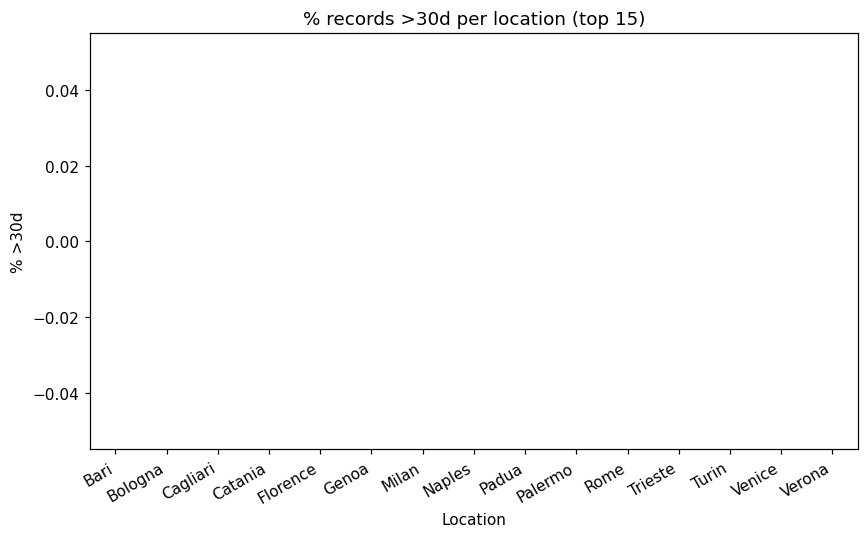

In [13]:
# 07: Temporal analysis (refactor + breakdown per location)
from pathlib import Path

# 07.1: Analisi temporale
temp = TemporalAnalyzer()
df_temp, temp_report = temp.analyze(df, target=VALUATION_K)
print(temp_report)

# 07.2: Plot temporali + salvataggio figura
fig = temp.plot(df_temp, target=VALUATION_K)

fig_dir = Path("outputs/analysis/figures")
fig_dir.mkdir(parents=True, exist_ok=True)
_savefig("temporal_analysis.png"); plt.show()
print(f"📈 Figure saved: {fig_dir / 'temporal_analysis.png'}")
plt.show()

# 07.3: Export report JSON
from notebooks.shared.common.utils import canonical_json_dumps
temp_json = ANALYSIS_DIR / "temporal_report.json"
temp_json.write_text(canonical_json_dumps(temp_report), encoding="utf-8")
print(f"Saved: {temp_json}")

# 07.4: Breakdown freschezza per location (tabella + barplot)
try:
    if "days_since_verification" in df_temp.columns and LOCATION in df_temp.columns:
        ths = [30, 60, 90]
        grp = df_temp.groupby(LOCATION, observed=True)

        fresk = pd.DataFrame({"count": grp.size()})
        for th in ths:
            flag_col = f"is_stale_{th}d"
            if flag_col in df_temp.columns:
                fresk[f"pct_over_{th}d"] = (grp[flag_col].mean() * 100).astype(float)
            else:
                fresk[f"pct_over_{th}d"] = np.nan

        fresk = fresk.sort_values("pct_over_30d", ascending=False)

        fresk_csv  = ANALYSIS_DIR / "freshness_by_location.csv"
        fresk_parq = ANALYSIS_DIR / "freshness_by_location.parquet"
        fresk.to_csv(fresk_csv, encoding="utf-8")
        fresk.to_parquet(fresk_parq)
        print(f"💾 Saved: {fresk_csv}, {fresk_parq}")

        # barplot % >30d (top 15)
        top = fresk.head(15)
        ax = top["pct_over_30d"].plot(kind="bar")
        ax.set_title("% records >30d per location (top 15)")
        ax.set_ylabel("% >30d")
        ax.set_xlabel("Location")
        plt.xticks(rotation=30, ha="right")
        plt.tight_layout()
        _savefig("freshness_over30_by_location.png")
        print(f"📈 Figure saved: {fig_dir / 'freshness_over30_by_location.png'}")
        plt.show()
    else:
        print("ℹ️ Breakdown per location non disponibile (manca 'days_since_verification' o 'location').")
except Exception as e:
    print(f"⚠️ Impossibile calcolare il breakdown per location: {e}")

### Insights

In [14]:
# 08: Insights sintetici + export
ins = InsightsAnalyzer(top_n=5)
insights = ins.generate_value_insights(df)

ins_json = ANALYSIS_DIR / "insights.json"
ins_json.write_text(canonical_json_dumps(insights), encoding="utf-8")
print(f"Saved: {ins_json}")

# anteprime
top_val = insights.get("top_assets", {}).get("by_valuation", {}).get("data", [])
worst = insights.get("worst_assets", {}).get("by_condition", {}).get("data", [])
display(pd.DataFrame(top_val).head(10))
display(pd.DataFrame(worst).head(10))

Saved: outputs\analysis\insights.json


,asset_id,valuation_k,size_m2,energy_class,condition_score
0,asset_014315,2304.21,199,A,0.825
1,asset_001251,2216.10,197,A,0.865
2,asset_011374,2209.80,199,B,0.861
3,asset_002316,2164.38,191,C,0.833
4,asset_009200,2153.18,198,B,0.698


,asset_id,valuation_k,energy_class,condition_score,luxury_score
0,asset_003283,742.99,G,0.484,0.4
1,asset_000618,162.12,G,0.499,0.2
2,asset_012459,354.23,G,0.500,0.4
3,asset_013356,171.39,G,0.504,0.4
4,asset_002419,189.67,G,0.507,0.4


### Outlier Analysis (IQR)

In [15]:
# 09.1–09.2: Outlier detection (IQR) → combine → stats → export (Parquet/JSON)
from notebooks.shared.n02_explore_dataset.eda_core import DEFAULT_NUMERIC_FEATURES, LEAKY_FEATURES
from pathlib import Path

numeric_cols = [c for c in DEFAULT_NUMERIC_FEATURES if c in df.columns and c not in LEAKY_FEATURES]

od = OutlierDetector(method="iqr", iqr_multiplier=1.5)  # niente output_dir qui
out_summary = od.detect_outliers(df, columns=numeric_cols)

combined = od.combine_outlier_results(df, out_summary)
stats = od.get_outlier_summary_stats(df, out_summary, combined)

out_dir = Path("outputs/analysis/outliers")
out_dir.mkdir(parents=True, exist_ok=True)

# Salvataggi (solo se c’è qualcosa)
(out_dir / "outliers_summary.json").write_text(
    canonical_json_dumps(drift_report),
    encoding="utf-8"
)
if not combined.empty:
    combined.to_parquet(out_dir / "outliers_combined.parquet", index=False)
    combined.to_csv(out_dir / "outliers_combined.csv", index=False, encoding="utf-8")
    display(combined.head(10))
else:
    print("Nessun outlier combinato da salvare.")

,index,outlier_source,outlier_count,n_outlier_sources,asset_id,asset_type,location,valuation_k,price_per_sqm,last_verified_ts,...,luxury_score,env_score,orientation,view,condition,heating,confidence_score,strongly_incoherent,prediction_ts,lag_hours
0,62,[valuation_k],494,1,asset_000062,property,Bologna,1346.64,7087.57,2025-08-21 06:40:21+00:00,...,0.8,0.6,North-East,inner courtyard,renovated,autonomous,0.7965,False,2025-08-21 06:41:48.632909+00:00,0.024342
339,9776,[valuation_k],494,1,asset_009776,property,Milan,1225.71,7660.71,2025-08-21 06:40:32+00:00,...,0.8,0.6,North-West,garden,needs_renovation,autonomous,0.7550,False,2025-08-21 06:41:48.632909+00:00,0.021287
337,9688,[valuation_k],494,1,asset_009688,property,Milan,1280.44,10582.14,2025-08-21 06:40:32+00:00,...,0.8,0.6,West,garden,new,centralized,0.7775,False,2025-08-21 06:41:48.632909+00:00,0.021287
336,9685,[valuation_k],494,1,asset_009685,property,Milan,1533.17,8965.90,2025-08-21 06:40:32+00:00,...,0.6,1.0,West,landmarks,renovated,autonomous,0.7575,False,2025-08-21 06:41:48.632909+00:00,0.021287
335,9626,[valuation_k],494,1,asset_009626,property,Rome,1141.09,6832.88,2025-08-21 06:40:32+00:00,...,0.8,0.4,East,street,good,autonomous,0.6805,False,2025-08-21 06:41:48.632909+00:00,0.021287
334,9562,[valuation_k],494,1,asset_009562,property,Milan,1342.50,7584.74,2025-08-21 06:40:32+00:00,...,0.4,0.0,North-West,park,good,centralized,0.5565,True,2025-08-21 06:41:48.632909+00:00,0.021287
333,9527,[valuation_k],494,1,asset_009527,property,Milan,1267.05,6775.68,2025-08-21 06:40:32+00:00,...,0.8,0.4,North,inner courtyard,renovated,autonomous,0.7465,False,2025-08-21 06:41:48.632909+00:00,0.021287
332,9524,[valuation_k],494,1,asset_009524,property,Milan,1938.93,9892.50,2025-08-21 06:40:32+00:00,...,0.2,0.6,North-West,sea,renovated,autonomous,0.5740,True,2025-08-21 06:41:48.632909+00:00,0.021287
331,9519,[valuation_k],494,1,asset_009519,property,Milan,1701.06,8723.37,2025-08-21 06:40:32+00:00,...,0.6,0.3,North-East,inner courtyard,good,autonomous,0.6900,False,2025-08-21 06:41:48.632909+00:00,0.021287
330,9512,[valuation_k],494,1,asset_009512,property,Rome,1214.49,6196.36,2025-08-21 06:40:32+00:00,...,0.8,0.6,East,inner courtyard,good,heat pump,0.7410,False,2025-08-21 06:41:48.632909+00:00,0.021287


### ML Preparation Insights

In [16]:
# 10.1: Prepara features (no leakage) e calcola importances — robusto + LIGHT mode
import os
from pathlib import Path
import pandas as pd

ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)

LIGHT = os.getenv("EDA_MODE", "light").lower() == "light"
permute = not LIGHT
n_repeats = int(os.getenv("EDA_PERM_REPEATS", 3 if LIGHT else 5))

fia = FeatureImportanceAnalyzer(target_column=VALUATION_K, n_estimators=200, random_state=42)
X, y, feats = fia.prepare_features(df, include_proxies=False)

imps = fia.calculate_importances(X, y, calculate_permutation=permute, n_repeats=n_repeats)

imp_builtin = imps.get("builtin", pd.DataFrame()).reset_index(drop=True)
imp_perm = imps.get("permutation", pd.DataFrame())
imp_perm = imp_perm.reset_index(drop=True) if isinstance(imp_perm, pd.DataFrame) else pd.DataFrame()

display(imp_builtin.head(15))
if not imp_perm.empty:
    display(imp_perm.head(15))
else:
    if permute:
        print("ℹ️ Permutation importances not available; check estimator/params.")
    else:
        print("ℹ️ LIGHT mode: permutation importances skipped.")

# export importances
if not imp_builtin.empty:
    imp_builtin.to_csv(ANALYSIS_DIR / "feature_importances_builtin.csv", index=False)
    imp_builtin.to_parquet(ANALYSIS_DIR / "feature_importances_builtin.parquet", index=False)
if not imp_perm.empty:
    imp_perm.to_csv(ANALYSIS_DIR / "feature_importances_permutation.csv", index=False)
    imp_perm.to_parquet(ANALYSIS_DIR / "feature_importances_permutation.parquet", index=False)

# 10.2: Ablation “light” (parametrizzata)
top_n = int(os.getenv("EDA_ABLATION_TOPN", 3 if LIGHT else 5))
cv_folds = int(os.getenv("EDA_ABLATION_CV", 2 if LIGHT else 3))
top_feats = imp_builtin.head(top_n)["feature"].tolist()

if top_feats:
    abl = fia.perform_ablation_study(X, y, features_to_ablate=top_feats, cv_folds=cv_folds)
    display(abl)
    abl.to_csv(ANALYSIS_DIR / "ablation_study.csv", index=False)
    abl.to_parquet(ANALYSIS_DIR / "ablation_study.parquet", index=False)
else:
    print("⚠️ No features available for ablation study.")

,feature,importance
0,distance_to_center_km,0.241116
1,confidence_score,0.134776
2,region_encoded,0.080186
3,location_encoded,0.071414
4,year_built,0.065730
5,air_quality_index,0.045741
6,strongly_incoherent,0.044243
7,humidity_level,0.043682
8,noise_level,0.035629
9,temperature_avg,0.033626


ℹ️ LIGHT mode: permutation importances skipped.


,n_features,mean_r2,std_r2,mean_mae,std_mae,r2_drop,r2_drop_pct
setting,,,,,,,
full,32,0.555602,0.016888,144.484620,1.361135,0.000000,0.000000
no_region_encoded,31,0.544112,0.009954,147.148782,0.371380,0.011489,2.067905
no_confidence_score,31,0.481953,0.018849,158.876314,1.654093,0.073649,13.255745
no_distance_to_center_km,31,0.372839,0.000716,174.520993,1.611357,0.182762,32.894520
no_all,29,0.268153,0.007200,190.525558,1.946927,0.287449,51.736473


### EDAReportRunner (one-shot + manifest EDA)


In [ ]:
from notebooks.shared.n02_explore_dataset.eda_reports import EDAReportRunner

runner = EDAReportRunner(
    output_dir=str(ANALYSIS_DIR),
)

eda_manifest = runner.run_full_eda(df)
print("EDA manifest written:", eda_manifest.get("manifest_path"))

EDA manifest written: outputs\analysis\eda_manifest.json
